In [1]:
%cd ..
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # use cpu because I'm training on gpu

# from thumbs.experiments.pokemon_conditional_types_v4_deep import PokemonExperiment
from thumbs.viz import show_samples, visualize_preprocessed_image
from thumbs.data import load_and_preprocess_image
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt


/home/anthony/workspace/yt-data


2023-09-03 17:05:46.456857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 821 total files
Found 819 jpgs


  0%|          | 0/819 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

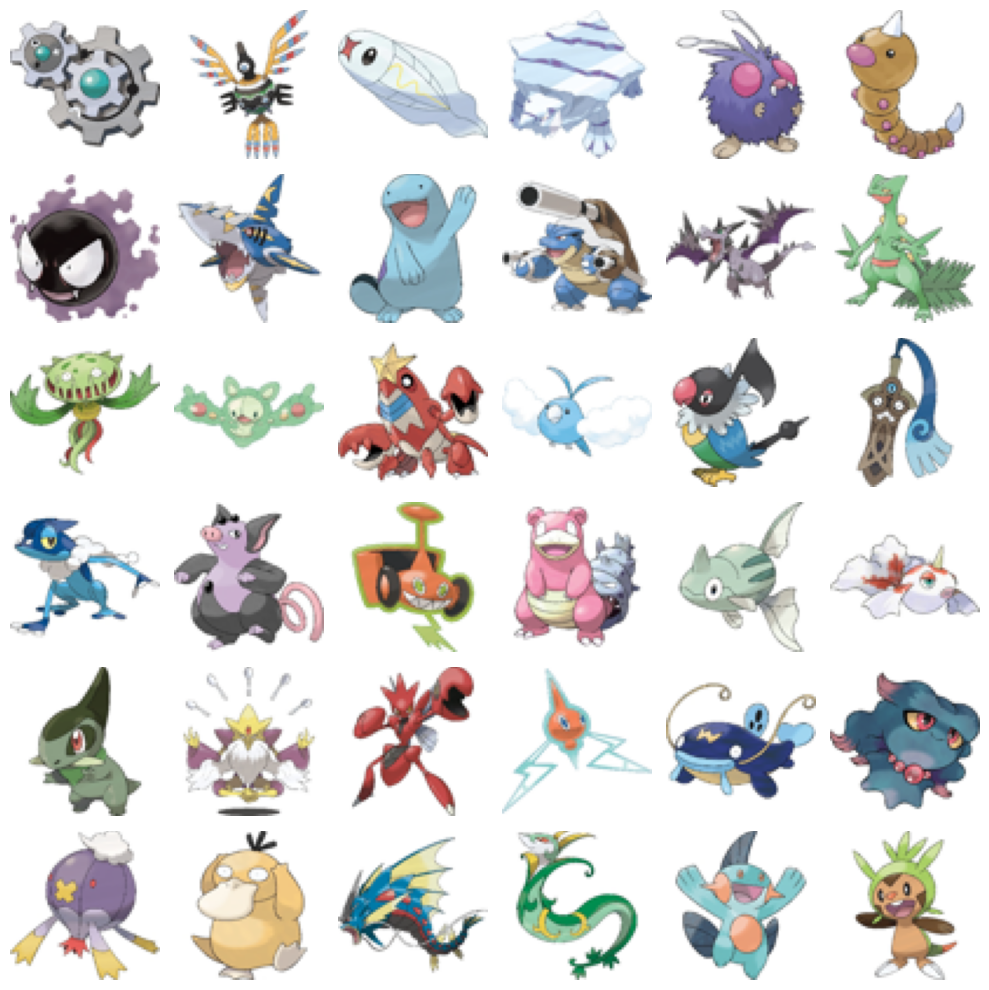

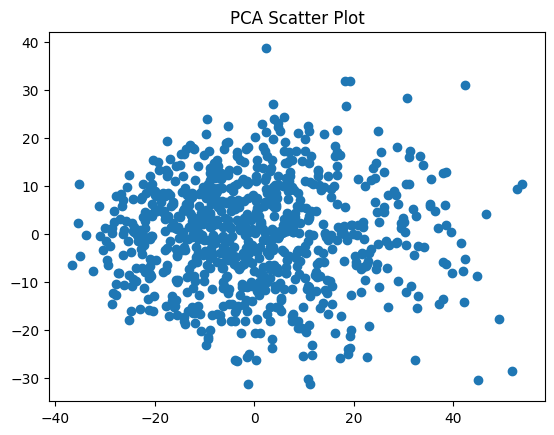

2023-09-03 17:05:50.449827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
from thumbs.data import get_pokemon_data256

data = tf.data.Dataset.from_tensor_slices(get_pokemon_data256((64,64,3))).batch(1).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [3]:
from thumbs.params import DiffusionHyperParams

mparams = DiffusionHyperParams(
    learning_rate=0.0002,
    batch_size=128,
    adam_b1=0.5,
    iterations=10000,
    sample_interval=1,

    T=300,
    beta=0.008

)

print(f'Datset length {len(data)}')

def forward_diffusion_sample(x_0, t, device='/cpu:0'):
    """
    x_0: Initial images, shape (batch_size, height, width, channels)
    t: timestep
    beta_schedule: A list or tensor of noise levels, beta, at each timestep
    device: 'CPU:0' or 'GPU:0' etc.
    """
    with tf.device(device):
        # x = tf.cast(x_0, tf.float32) # TODO Maybe don't need?
        x = x_0
        
        # Loop through the timesteps up to t
        final_noise = None
        for i in range(t):
            beta = mparams.beta_schedule[i]  # Get beta for this timestep
            noise = tf.random.normal(shape=x.shape, mean=0., stddev=1.)  # Generate random noise
            noise_scaled = tf.math.sqrt(beta) * noise  # Scale the noise
            if final_noise is None:
                final_noise = noise_scaled
            else:
                final_noise = final_noise + noise_scaled
            x = x * (1 - beta) + noise_scaled  # Add the noise to x

    return x, final_noise

Datset length 819


In [4]:
# Calculate alpha values from beta
alpha_schedule = [1 - beta for beta in mparams.beta_schedule]

# Cumulative product of alphas and sqrt
sqrt_alphas_cumprod = [tf.math.sqrt(tf.math.reduce_prod(alpha_schedule[:t+1])) for t in range(len(alpha_schedule))]
sqrt_one_minus_alphas_cumprod = [tf.math.sqrt(1 - tf.math.reduce_prod(alpha_schedule[:t+1])) for t in range(len(alpha_schedule))]

def forward_diffusion_sample(x_0, t, device="/cpu:0"):
    with tf.device(device):
        # Make sure x_0 is float
        x = tf.cast(x_0, tf.float32)
        
        # Grab the pre-computed scaling terms for timestep t
        sqrt_alpha_t = sqrt_alphas_cumprod[t]
        sqrt_one_minus_alpha_t = sqrt_one_minus_alphas_cumprod[t]
        
        # Generate random noise
        noise = tf.random.normal(shape=x.shape, mean=0., stddev=1.)
        
        # Calculate the noised-up image using the pre-computed scaling terms
        x_noisy = sqrt_alpha_t * x + sqrt_one_minus_alpha_t * noise

    return x_noisy, noise



In [5]:
for i in mparams.beta_schedule:
    print(i)


tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(2.6755853e-05, shape=(), dtype=float32)
tf.Tensor(5.3511707e-05, shape=(), dtype=float32)
tf.Tensor(8.026756e-05, shape=(), dtype=float32)
tf.Tensor(0.000107023414, shape=(), dtype=float32)
tf.Tensor(0.00013377926, shape=(), dtype=float32)
tf.Tensor(0.00016053511, shape=(), dtype=float32)
tf.Tensor(0.00018729096, shape=(), dtype=float32)
tf.Tensor(0.00021404683, shape=(), dtype=float32)
tf.Tensor(0.00024080268, shape=(), dtype=float32)
tf.Tensor(0.00026755853, shape=(), dtype=float32)
tf.Tensor(0.00029431438, shape=(), dtype=float32)
tf.Tensor(0.00032107023, shape=(), dtype=float32)
tf.Tensor(0.00034782608, shape=(), dtype=float32)
tf.Tensor(0.00037458193, shape=(), dtype=float32)
tf.Tensor(0.0004013378, shape=(), dtype=float32)
tf.Tensor(0.00042809366, shape=(), dtype=float32)
tf.Tensor(0.0004548495, shape=(), dtype=float32)
tf.Tensor(0.00048160536, shape=(), dtype=float32)
tf.Tensor(0.0005083612, shape=(), dtype=float32)
tf.Tensor(0.0

## Show the noise steps

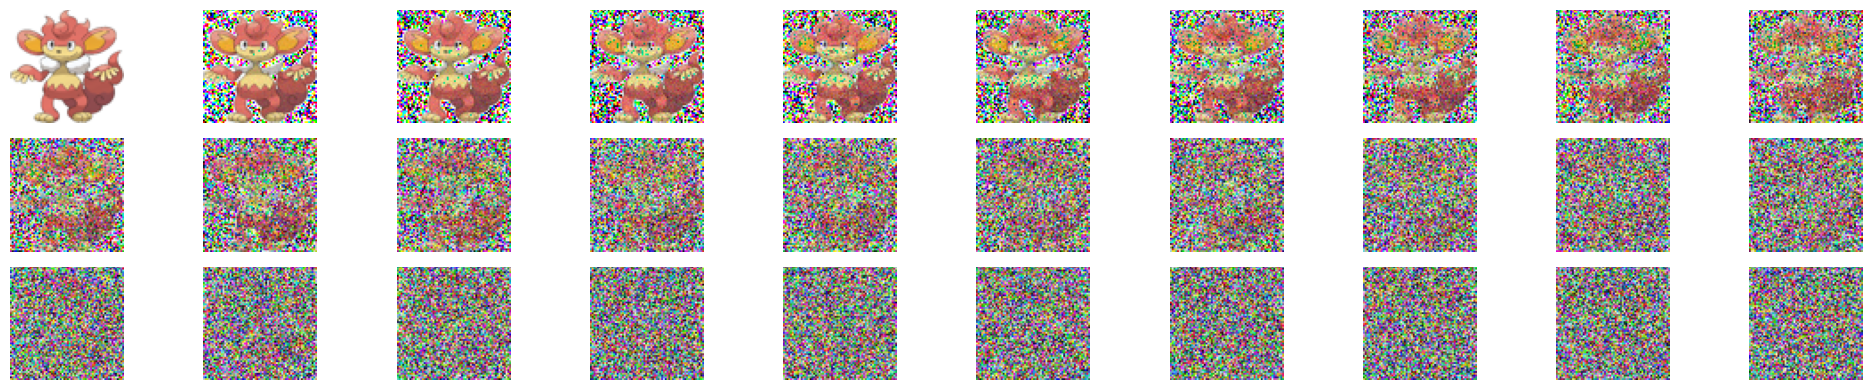

In [6]:
# Show a plot with  each image in a single row
from thumbs.util import unnormalize_image

it = iter(data)
for i in range(10):
    next(it)
item = next(it)

step_size = 10

ncols = 10
nrows = int(int(mparams.T/step_size) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4))

last_img = None
last_noise = None
images = []

for i, t in enumerate(range(0, mparams.T, step_size)):
    img, noise = forward_diffusion_sample(item, t)
    img = unnormalize_image(img[0].numpy())
    images.append(img)


images.reverse()
for i in range(nrows):
    for j in range(ncols):
        axes[i,j].imshow(images.pop())
        axes[i,j].axis('off')  # Hide the axes ticks and labels
        last_img = img
        last_noise = noise

plt.subplots_adjust(wspace=0.0, hspace=0)
plt.tight_layout()
plt.show()


## Make sure the noise is sufficeint by showing the overlap between T and original

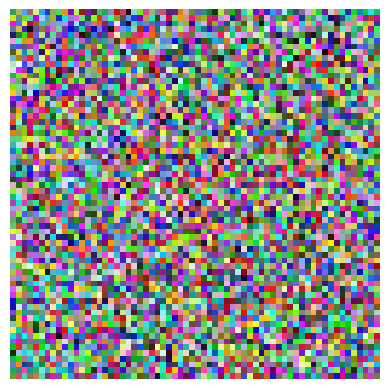

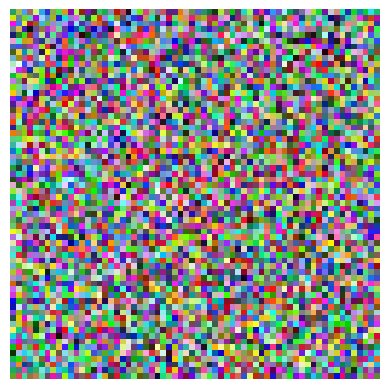

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(last_img)
plt.axis('off')
plt.show()

# Show the blended image using matplotlib, since we're sticking to Python libraries here
recovered = (last_img - last_noise[0]).numpy().astype(np.uint8)
plt.imshow(recovered)
plt.axis('off')
plt.show()



# Do it again using the real code

Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 821 total files
Found 819 jpgs


/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


  0%|          | 0/819 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

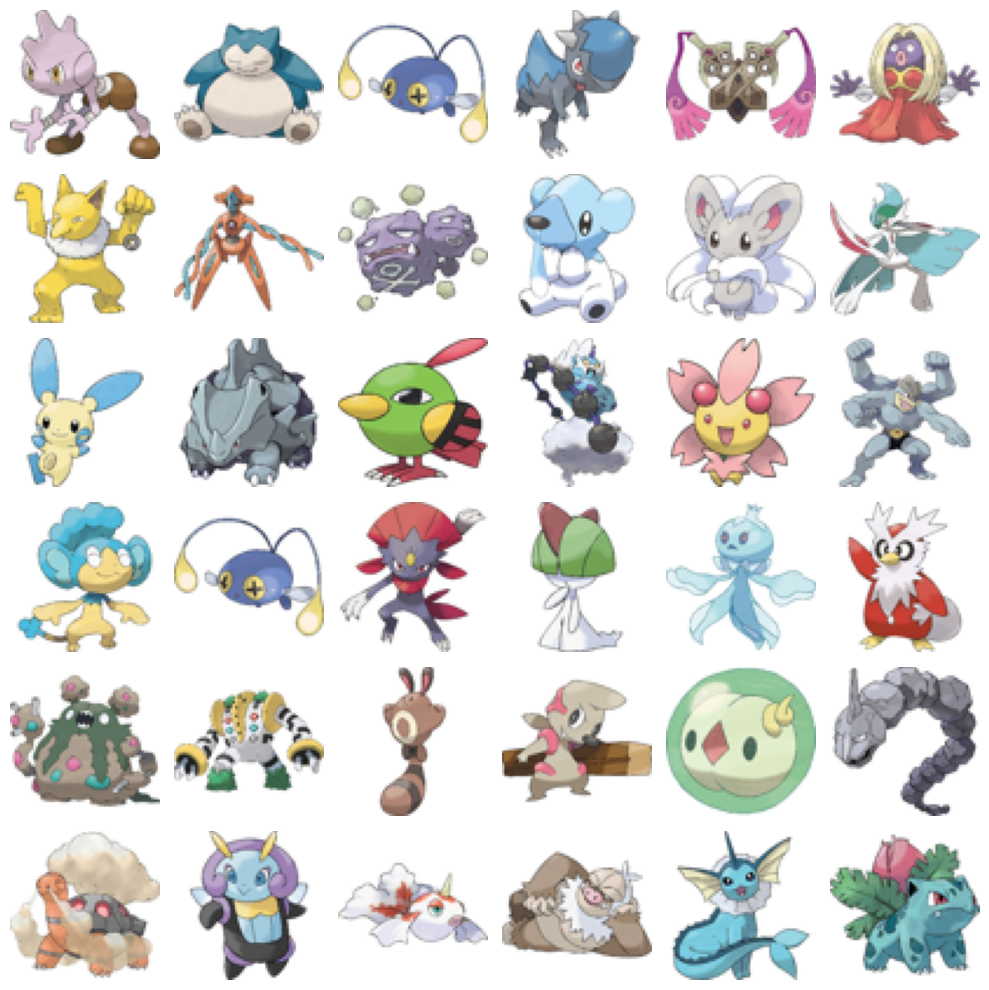

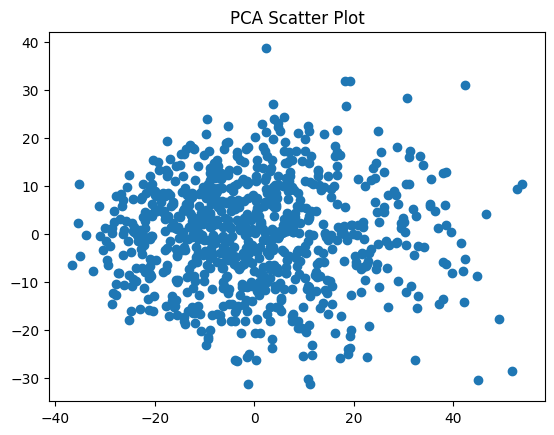

Model: "diffusion_model"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                               Output Shape                                                Param #             Connected to                                                
 t (InputLayer)                                             [(None, 1)]                                                 0                   []                                                          
                                                                                                                                                                                                        
 image (InputLayer)                                         [(None, 64, 64, 3)]                                         0                   []                             

In [8]:
from thumbs.experiments.pokemon_diffusion import MyExperiment 
from thumbs.train  import TrainDiffusion

exp = MyExperiment()
mparams = exp.get_mutable_params()[0]
train: TrainDiffusion = exp.get_train(exp.get_model(mparams).build(), mparams)

In [9]:
data = exp.get_data()
data = tf.data.Dataset.from_tensor_slices(data)
exp.prepare_data(data, mparams)

train.show_samples(data)

ValueError: Input 0 of layer "diffusion_model" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(1, 4, 64, 3)

(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)


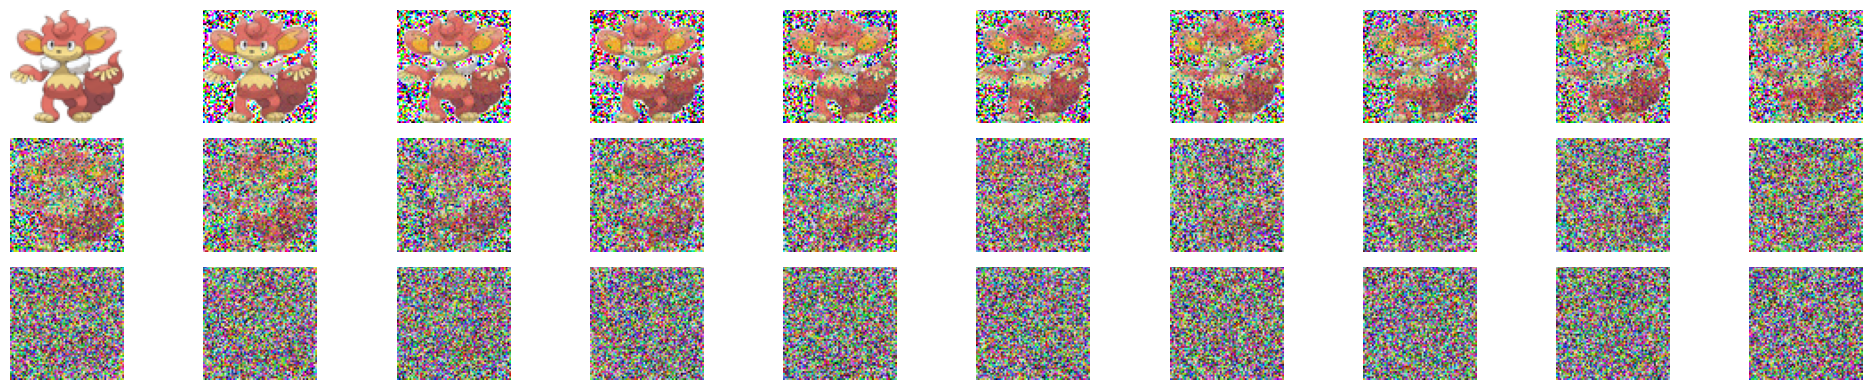

In [9]:
# Show a plot with  each image in a single row
from thumbs.util import unnormalize_image

it = iter(data)
for i in range(10):
    next(it)
item = next(it)

step_size = 10

ncols = 10
nrows = int(int(mparams.T/step_size) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4))

last_img = None
last_noise = None
images = []

for i, t in enumerate(range(0, mparams.T, step_size)):
    print(item.shape)
    img, noise = train.forward_diffusion_sample(item, t)
    img = unnormalize_image(img[0].numpy())
    images.append(img)


images.reverse()
for i in range(nrows):
    for j in range(ncols):
        axes[i,j].imshow(images.pop())
        axes[i,j].axis('off')  # Hide the axes ticks and labels
        last_img = img
        last_noise = noise

plt.subplots_adjust(wspace=0.0, hspace=0)
plt.tight_layout()
plt.show()
